# 权重衰退
基本思想是通过限制参数值的选择范围来控制模型容量。
可以使用如下的均方范数作为柔性限制：
$$ min\text{  } l(w,b) + \frac{\lambda}{2}||w||^2$$
其中超参数$\lambda$起到了控制正则项的重要程度的功能。其中$$||w||^2$$被称为罚。

## 时间t更新参数
根据上面的均方范数作为总损失函数，可以更新相关的梯度：
$$\pmb{w}_{t+1} = (1-\eta\lambda)\pmb{w}_t-\eta\frac{\partial\mathcal{l}(\pmb{w}_t,b_t)}{\partial{\pmb{w}_t}}$$
其中这样的更新成为了`权重衰退`。

## 代码实现

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /opt/anaconda3/envs/cs224n/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


根据下面的公式生成一些人工的数据集：
$$y=0.05 + \sum\limits_{i=1}^d0.01x_i = \epsilon \text{     } where\text{       } \epsilon \to \mathcal{N}(0,0.01^2)$$
选用一个比较简单的数据集来更容易过拟合，可以更好的反应权重衰退的效果。

In [3]:
n_train,n_test,num_inputs,batch_size = 20,100,200,5
true_w,true_b = torch.ones((num_inputs,1)) * 0.01,0.05
train_data = d2l.synthetic_data(true_w,true_b,n_train) # 生成一个人工数据集的函数
train_iter = d2l.load_array(train_data,batch_size=batch_size)
test_data = d2l.synthetic_data(true_w,true_b,n_test)
test_iter = d2l.load_array(test_data,batch_size,is_train=False)

### 初始化模型参数

In [4]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

### 定义$L_2$范数惩罚

In [5]:
def l2_penalty(w):
  return torch.sum(w.pow(2)) / 2

### 定义训练代码的实现

In [8]:
def train(lambd):
    w,b = init_params()
    net,loss = lambda X:d2l.linreg(X,w,b),d2l.squared_loss
    num_epochs,lr = 100,0.03
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            #with torch.enable_grad():
            l = loss(net(X),y) + lambd * l2_penalty(w) # 加上损失做一次梯度下降
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if (epoch+1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    
    print('w的L2范数是',torch.norm(w).item())

### 忽略正则化直接实现 已经过拟合

w的L2范数是 13.828883171081543


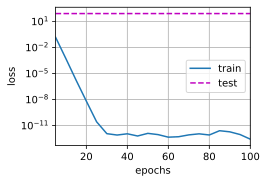

In [10]:
train(lambd=0) # 相当于没有做权重衰减

### 加入正则化 对噪音过拟合处理较好

w的L2范数是 0.03205038607120514


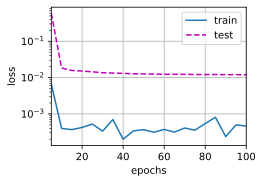

In [15]:
train(lambd=4) # 进行了权重衰退 有罚

### 简洁实现

In [16]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd}, # 这里在做SGD随机梯度下降的时候引入了权重衰退参数
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 14.452237129211426


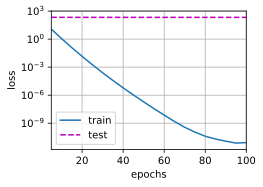

In [17]:
train_concise(0)

w的L2范数： 0.2320472151041031


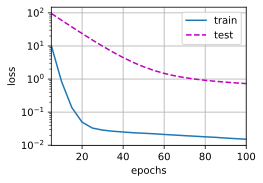

In [22]:
train_concise(4)